In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import font_manager, rc
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
from PIL import Image
import random
from gensim import corpora
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
import nltk

In [10]:
##############################################################################
webnovel_title = '고수, 후궁으로 깨어나다'         # 웹소설 제목 변수 설정
Graph_number = 100                 # 50개 그래프 또는 100개 그래프 선택.

In [11]:
#############불용어 리스트 정리를 잘 해야 불용어, 치환이 가능함 ################
# 불용어 목록
del_list = ['를', '이', '은', '는', '있다', '하다', '에', 'ㅠ', 'ㅋ', 
            '건가', 'ㅎ', '일이', '무슨', '대한', '슈도', '뭔가', '진짜',
            '정말', '생각', '사람', '보고', '누구', '정도', '위해', '때문', '이건',
            '어디', '가장', '아주', '제일', '그냥', '해도', '하나', '얼마나', '자기',
            '부분', '어찌', '도', '저런', '자신']


In [12]:
# 단어를 치환하는 것(예를 들어 부수를 부수의로 치환해서 계산하는 것임)
word_mapped = {"십일": "십일낭", "십일랑": "십일낭", "십일": "십일낭",
               "순이": "사순", "안이": "안이낭", "삼부": "삼부인", "령의": "서령의",
               "나십일랑": "십일낭", "나십일낭": "십일낭", "나십일": "십일낭",
               "일낭": "십일낭", "일랑": "십일낭", "십일랑도": "십일낭",
               "십일": "십일낭", "11낭": "십일낭", "십일낭도": "십일낭",
               "노부": "노부인", "신가": "신가아", "령관": "서령관",
               "이부": "이부인", "오부": "오부인", "유가": "유가아"}

In [13]:

##############################################################################
# 한글 폰트 설정
font_path = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
##############################################################################
# 데이터 파일 로드
df = pd.read_excel(f'{webnovel_title}-Total_collected_data.xlsx', na_values=['NaN'])  # 데이터 로드
df = df.dropna()  # NaN 값을 가진 행 제거
df.reset_index(drop=True, inplace=True)  # 인덱스 재설정

# 리뷰 데이터 추출 및 전처리
articles = df['Review'].tolist()
print("Total articles:", len(articles))


Total articles: 20297


In [14]:
# 제한된 문자 수로 자르기
articles = ' '.join(articles)
articles = articles[:1000000000]  # 최대 분석할 문자 수 제한(여기 잘 선택해야함)

### (1) Graph (50 or 100)

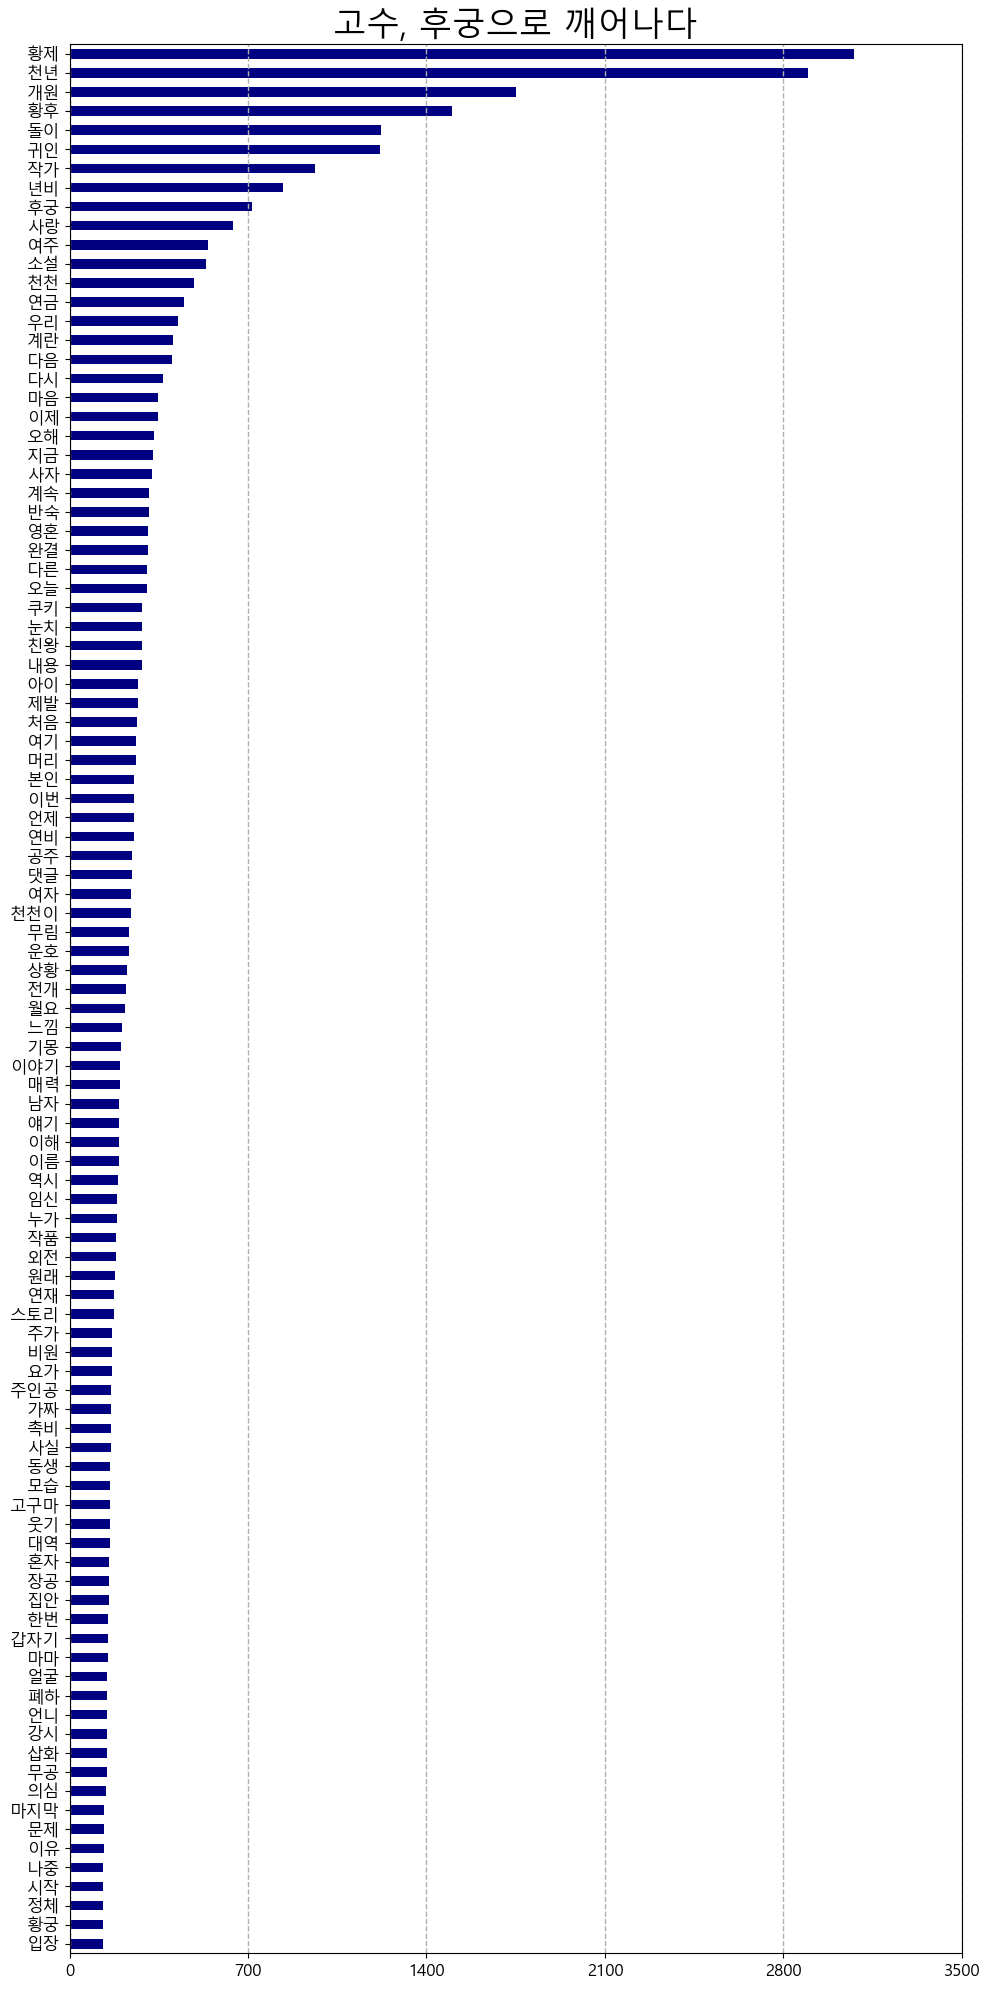

In [15]:
# 명사 추출을 위한 토크나이저 설정
tokenizer = Okt()
nouns = tokenizer.nouns(articles)  # 명사만 추출

# 단어 정리 및 매핑 적용
word_cleaned = []
for word in nouns:
    if word in word_mapped:
        word = word_mapped[word]  # '부수'를 '부수의'로 변경
    if len(word) > 1 and word not in del_list:
        word_cleaned.append(word)

# 빈도 계산
result = Counter(word_cleaned)
word_dic = dict(result)
sorted_word_dic = sorted(word_dic.items(), key=lambda x: x[1], reverse=True)

# 빈도 데이터 프레임
word_frequency = nltk.FreqDist(word_cleaned)
df_freq = pd.DataFrame(list(word_frequency.values()), word_frequency.keys())

# 상위 NN개 단어 추출 및 정렬
result = df_freq.sort_values([0], ascending=False)
result = result[:Graph_number]  # 상위 Graph_number 개 단어만 정리
result = result.iloc[::-1]  # 데이터를 뒤집어서 그래프 그리기

# 수평 막대 그래프 그리기
if Graph_number == 50:
    result.plot(kind='barh', legend=False, figsize=(10, 14), color='navy')  
elif Graph_number == 100:
    result.plot(kind='barh', legend=False, figsize=(10, 20), color='navy')

plt.title(webnovel_title, fontsize=24)  # 변수를 이용해 그래프 타이틀 설정

# x축 눈금 설정
max_value = result[0].max()
tick_spacing = (max_value // 4 // 100) * 100  # 5개의 눈금으로 나눌 간격 설정
plt.gca().set_xticks(np.arange(0, max_value + tick_spacing, tick_spacing)) 

plt.grid(True, which='major', axis='x', linestyle='--', linewidth=1.0)
plt.tick_params(axis='both', which='major', labelsize=12)  # x,y 축 눈금 크기
plt.tight_layout()

# 그래프 저장 및 표시
plt.savefig(f'{webnovel_title}-Graph-{Graph_number}.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


### (2) Word Cloud 생성

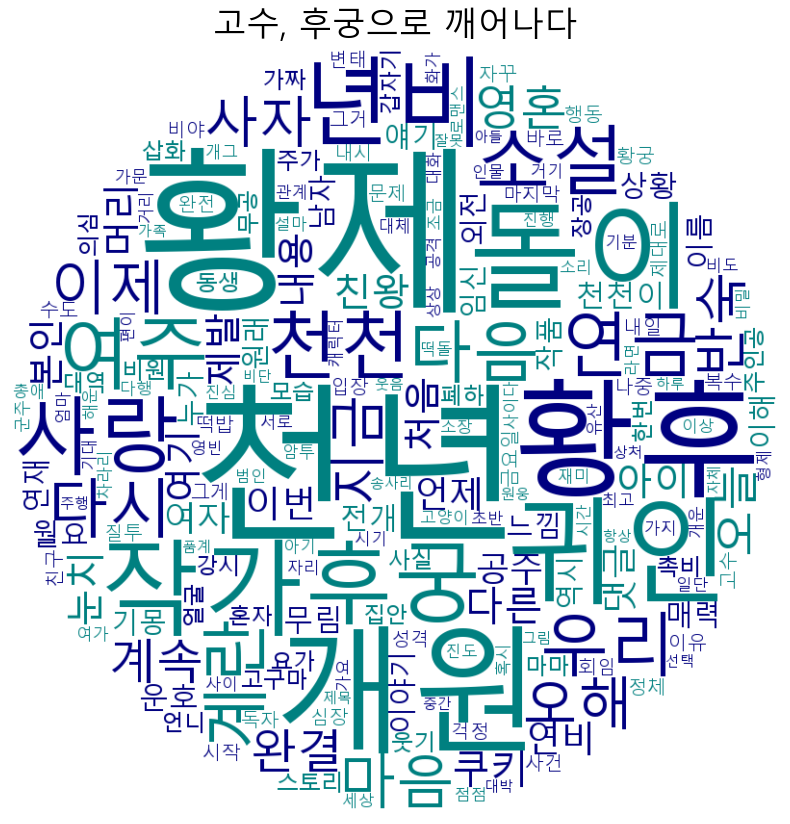

In [16]:
# WordCloud 생성 ##############################################################
# 색상 범위 지정
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#008080', '#000080']  # teal과 navy
    return random.choice(colors)

# 원형 마스크 생성
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)

# 워드 클라우드 설정
wc = WordCloud(
    font_path=font_path,
    background_color='white',
    mask=mask,
    width=800,
    height=800,
    max_words=200,
    max_font_size=180,
    color_func=color_func,  # 다양한 색상으로 설정
    prefer_horizontal=0.9,
    random_state=42)

wc.generate_from_frequencies(word_dic)    # 워드 클라우드 생성

# 워드 클라우드 표시
plt.figure(figsize=(10, 10))
plt.title(webnovel_title, fontsize=24)  # 변수를 이용해 그래프 타이틀 설정
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.savefig(f'{webnovel_title}-형태소.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()